In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation_models_pytorch

     |████████████████████████████████| 71kB 942kB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
     |████████████████████████████████| 245kB 10.5MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12421 sha256=2355ada152e8d108c427557997948326f58f4a536916fc5a4b21fbc255b67d98
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=b9d610970cc354562c8cef113afa8159aeeedcba3a6078d6b20926924fd49a09
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
import os

import albumentations as albu
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from albumentations.pytorch import ToTensor
from PIL import Image
from torchvision import  transforms
from torch.utils.data import DataLoader

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load Video

In [ ]:
VIDEO_PATH = "videoplayback.mp4"
MEAN_FOR_NORMALIZE = np.array([0.485, 0.456, 0.406])
STD_FOR_NORMALIZE = np.array([0.229, 0.224, 0.225])

In [ ]:
test_video_capture = cv2.VideoCapture(VIDEO_PATH)

In [ ]:
def read_frames(video_capture, transforms = None):

    ret, frame = video_capture.read()

    amount_test_video_frames = int(test_video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_tensor = torch.zeros([amount_test_video_frames, 3, 640, 640])

    for index in range(amount_test_video_frames):
        
       frame = np.array(frame)
       frame = np.concatenate((frame[:,:,2:3], frame[:,:,1:2], frame[:,:,0:1]), axis = 2)
       sample = {'image': frame}
       if transforms is not None:
            sample = transforms(**sample)

       frames_tensor[index] = sample["image"]
       
       _, frame = video_capture.read()
    
    
    video_capture.release()
    cv2.destroyAllWindows()
  
    return(frames_tensor)

In [ ]:
test_transforms = albu.Compose([
                                  albu.Resize(640, 640, p=1),
                                  albu.Normalize(),
                                  ToTensor()
                                ])

In [ ]:
video_dataset = read_frames(video_capture=test_video_capture, transforms=test_transforms)
video_dataset.shape

torch.Size([1121, 3, 640, 640])

In [ ]:
def tensor_imshow(img, renormalize = False, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    img = img.numpy().transpose((1, 2, 0))

    if (renormalize == True):
        img = STD_FOR_NORMALIZE * img + MEAN_FOR_NORMALIZE
    img = np.clip(img, 0, 1)
    plt_ax.imshow(img)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

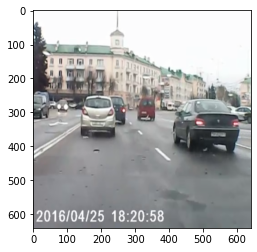

In [ ]:
tensor_imshow(video_dataset[200], renormalize = True)

In [ ]:
test_video_loader = DataLoader(
      video_dataset,
      batch_size=6,
      shuffle=False,
    )

# Test

In [ ]:
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/CompTech2021/model.pth"))
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
batch = next(iter(test_video_loader))
output = model(batch.to(device))

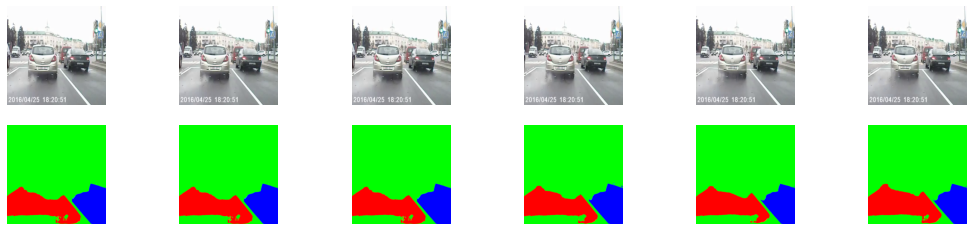

In [ ]:
plt.figure(figsize=(18, 4))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    tensor_imshow(batch[i], renormalize = True)
    plt.subplot(2, 6, i+7)
    plt.axis("off")
    tensor_imshow(output[i].to("cpu").detach(), renormalize = True)
plt.show();

# Make Video

In [ ]:
masking_video_name = '/content/drive/MyDrive/CompTech2021/masking_video.avi'
temp_image_name = '/content/drive/MyDrive/CompTech2021/temp_image.jpg'
temp_mask_name = '/content/drive/MyDrive/CompTech2021/temp_mask.jpg'
temp_masking_image_name = '/content/drive/MyDrive/CompTech2021/temp_masking_image.jpg'

masking_video = cv2.VideoWriter(masking_video_name, 0, 30, (640,640))

for batch in test_video_loader:

    output = model(batch.to(device))
    
    for image, mask in zip(batch, output.to("cpu").detach()):
        image = image.numpy().transpose((1, 2, 0))
        image = STD_FOR_NORMALIZE * image + MEAN_FOR_NORMALIZE
        image = np.clip(image, 0, 1)
        plt.imsave(temp_image_name, image)

        mask = mask.numpy().transpose((1, 2, 0))
        mask = STD_FOR_NORMALIZE * mask + MEAN_FOR_NORMALIZE
        mask = np.clip(mask, 0, 1)
        mask[:,:,1] = torch.zeros(640, 640)
        plt.imsave(temp_mask_name, mask)

        masking_image = cv2.addWeighted(cv2.imread(temp_image_name), 0.5, cv2.imread(temp_mask_name), 0.5, 0)
        masking_video.write(masking_image)


cv2.destroyAllWindows()
masking_video.release()